# Ejercicio de programación Regresión Polinomial

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# utilizado para manejos de directorios y rutas
import os

# Computacion vectorial y cientifica para python
import numpy as np

# Librerias para graficación (trazado de gráficos)
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # Necesario para graficar superficies 3D

# llama a matplotlib a embeber graficas dentro de los cuadernillos
%matplotlib inline

## 2 Regresión polinomica

Se implementa la regresion polinomial para predecir el la capacidad adquisitiva de una persona. El archivo `Datasets/capacidad_adquisitiva.csv` contiene un dataset para entrenamiento de capacidad adquisitiva de las personas considerando la edad de las personas de la ciudad de Sucre. La primera columna es la edad y la segunda columna es la capacidad adquisitiva en bolivianos por mes.

<a id="section4"></a>
### 2.1 Normalización de caracteristicas

Al visualizar los datos se puede observar que las caracteristicas tienen diferentes magnitudes, por lo cual se debe transformar cada valor en una escala de valores similares, esto con el fin de que el descenso por el gradiente pueda converger mas rapidamente.

In [4]:
import pandas as pd
import numpy as np
import os

# Montar Google Drive si estás en Google Colab
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("No estás usando Google Colab o no es necesario montar Google Drive.")

# Definir la ruta al archivo
file_path = '/content/gdrive/MyDrive/lab1/SolarPrediction.csv'  # Cambia según tu entorno

# Verificar si el archivo existe
if not os.path.exists(file_path):
    print(f"El archivo {file_path} no existe.")
else:
    # Cargar el archivo CSV
    try:
        data = pd.read_csv(file_path)
        print("Archivo CSV cargado correctamente.")
        print(data.head())
    except FileNotFoundError:
        print(f"El archivo {file_path} no se encontró.")
    except pd.errors.ParserError as e:
        print(f"Error al parsear el archivo CSV: {e}")
    except Exception as e:
        print(f"Error al cargar el archivo CSV: {e}")

    # Verificar las columnas y tipos de datos
    print("\nColumnas del CSV:")
    print(data.columns)

    print("\nTipos de datos de cada columna:")
    print(data.dtypes)

    # Define las columnas numéricas y la columna objetivo
    numeric_columns = ['Temperature', 'Pressure']  # Reemplaza con los nombres correctos
    target_column = 'Radiation'  # Reemplaza con el nombre correcto

    # Verificar la existencia de las columnas
    missing_columns = [col for col in numeric_columns + [target_column] if col not in data.columns]
    if missing_columns:
        print(f"Las siguientes columnas no se encontraron en el CSV: {missing_columns}")
    else:
        # Manejar valores faltantes
        print("\nValores faltantes por columna:")
        print(data[numeric_columns + [target_column]].isnull().sum())

        # Eliminar filas con valores faltantes
        data_clean = data.dropna(subset=numeric_columns + [target_column])

        # Convertir a numpy arrays después de limpiar
        X = data_clean[numeric_columns].values
        y = data_clean[target_column].values

        m = y.size
        print(f"\nTotal de ejemplos después de eliminar filas con valores faltantes: {m}")

        # Añadir columna de unos (intercepto)
        X = np.concatenate([np.ones((m, 1)), X], axis=1)

        # Imprimir algunos ejemplos
        print('\nPrimeros 10 ejemplos:')
        print('{:>8s}{:>8s}{:>10s}'.format('X[:,0]', 'X[:,1]', 'y'))
        print('-' * 26)
        for i in range(10):
            try:
                # Convertir a enteros si es necesario
                val1 = int(X[i, 0])
                val2 = int(X[i, 1])
                val3 = int(y[i])
                print('{:8d}{:8d}{:10d}'.format(val1, val2, val3))
            except ValueError as e:
                print(f"Error en la fila {i}: {e}")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archivo CSV cargado correctamente.
     UNIXTime                   Data      Time  Radiation  Temperature  \
0  1475229326  9/29/2016 12:00:00 AM  23:55:26       1.21           48   
1  1475229023  9/29/2016 12:00:00 AM  23:50:23       1.21           48   
2  1475228726  9/29/2016 12:00:00 AM  23:45:26       1.23           48   
3  1475228421  9/29/2016 12:00:00 AM  23:40:21       1.21           48   
4  1475228124  9/29/2016 12:00:00 AM  23:35:24       1.17           48   

   Pressure  Humidity  WindDirection(Degrees)  Speed TimeSunRise TimeSunSet  
0     30.46        59                  177.39   5.62    06:13:00   18:13:00  
1     30.46        58                  176.78   3.37    06:13:00   18:13:00  
2     30.46        57                  158.75   3.37    06:13:00   18:13:00  
3     30.46        60                  137.71   3.37    06:13:00   18:13:00  

La desviación estándar es una forma de medir cuánta variación hay en el rango de valores de una característica en particular (la mayoría de los puntos caeran en un rango de ± 2 en relación a la desviaciones estándar de la media); esta es una alternativa a tomar el rango de valores (max-min). En `numpy`, se puede usar la función `std` para calcular la desviacion estandar.

Por ejemplo, la caracteristica`X[:, 0]` contiene todos los valores de $x_1$ (edades) en el conjunto de entrenamiento, entonces `np.std(X[:, 0])` calcula la desviacion estandar de las edades.
En el momento en que se llama a la función `featureNormalize`, la columna adicional de unos correspondiente a $ x_0 = 1 $ aún no se ha agregado a $ X $.

<div class="alert alert-block alert-warning">
**Notas para la implementación:** Cuando se normalize una caracteristica, es importante almacenar los valores usados para la normalización - el valor de la media y el valor de la desviación estandar usado para los calculos. Despues de aprender los parametros del modelo, se deseara predecir la capacidad adquisitiva que no se han visto antes. Dado un nuevo valor de x (edad), primero se debe normalizar x usando la media y la desviacion estandar que se empleo anteriormente en el conjunto de entrenamiento para entrenar el modelo.
</div>
<a id="featureNormalize"></a>

In [6]:
def plotData(x, y):
    #Grafica los puntos x e y en una figura nueva.

    fig = pyplot.figure()  # abre una nueva figura

    pyplot.plot(x, y, 'ro', ms=10, mec='k')
    pyplot.ylabel('Edad personas')
    pyplot.xlabel('Capacidad adquisitiva 1,000s')


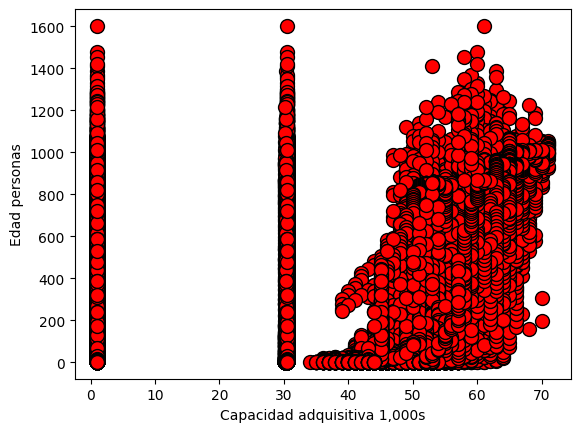

In [7]:
plotData(X, y)

In [8]:
X = np.concatenate([X, X * X], axis=1)

In [9]:
print(X)

[[1.000000e+00 4.800000e+01 3.046000e+01 1.000000e+00 2.304000e+03
  9.278116e+02]
 [1.000000e+00 4.800000e+01 3.046000e+01 1.000000e+00 2.304000e+03
  9.278116e+02]
 [1.000000e+00 4.800000e+01 3.046000e+01 1.000000e+00 2.304000e+03
  9.278116e+02]
 ...
 [1.000000e+00 4.400000e+01 3.042000e+01 1.000000e+00 1.936000e+03
  9.253764e+02]
 [1.000000e+00 4.400000e+01 3.042000e+01 1.000000e+00 1.936000e+03
  9.253764e+02]
 [1.000000e+00 4.400000e+01 3.043000e+01 1.000000e+00 1.936000e+03
  9.259849e+02]]


In [10]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [11]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X)

#print(X)
#print('Media calculada:', mu)
#print('Desviación estandar calculada:', sigma)
#print(X_norm)

<ipython-input-10-8d831078d311>:8: RuntimeWarning: divide by zero encountered in divide
  X_norm = (X - mu) / sigma
<ipython-input-10-8d831078d311>:8: RuntimeWarning: invalid value encountered in divide
  X_norm = (X - mu) / sigma


Despues de `featureNormalize` la funcion es provada, se añade el temino de interseccion a `X_norm`:

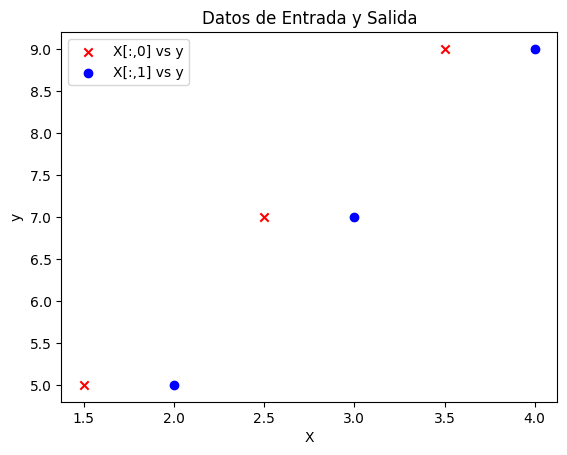

In [14]:
plotData(X_norm, y)

In [16]:
import numpy as np

# Supongamos que X_norm y y ya están definidos
# Ejemplo de X_norm
X_norm = np.array([[1.5, 2.0], [2.5, 3.0], [3.5, 4.0]])

# Número de ejemplos
m = X_norm.shape[0]

# Crear una columna de unos
unos = np.ones((m, 1))

# Concatenar la columna de unos con X_norm
X_ren = np.concatenate([unos, X_norm], axis=1)

# Mostrar las formas para verificar
print("Forma de X_norm:", X_norm.shape)
print("Forma de unos:", unos.shape)
print("Forma de X_ren:", X_ren.shape)

# Imprimir el resultado
print("X_ren:")
print(X_ren)


Forma de X_norm: (3, 2)
Forma de unos: (3, 1)
Forma de X_ren: (3, 3)
X_ren:
[[1.  1.5 2. ]
 [1.  2.5 3. ]
 [1.  3.5 4. ]]


In [17]:
print(X)

[[1.000000e+00 4.800000e+01 3.046000e+01 1.000000e+00 2.304000e+03
  9.278116e+02]
 [1.000000e+00 4.800000e+01 3.046000e+01 1.000000e+00 2.304000e+03
  9.278116e+02]
 [1.000000e+00 4.800000e+01 3.046000e+01 1.000000e+00 2.304000e+03
  9.278116e+02]
 ...
 [1.000000e+00 4.400000e+01 3.042000e+01 1.000000e+00 1.936000e+03
  9.253764e+02]
 [1.000000e+00 4.400000e+01 3.042000e+01 1.000000e+00 1.936000e+03
  9.253764e+02]
 [1.000000e+00 4.400000e+01 3.043000e+01 1.000000e+00 1.936000e+03
  9.259849e+02]]


<a id="section5"></a>
### 2.2 Descenso por el gradiente

En el ejemplo anterior se implemento el descenso por el gradiente para un problema de regresion univariable. La unica diferencia es que ahora existe una caracteristica adicional en la matriz $X$. La función de hipótesis y la regla de actualización del descenso del gradiente por lotes permanecen sin cambios.

La implementacion de las funciones `computeCostMulti` y `gradientDescentMulti` son similares a la funcion de costo y función de descenso por el gradiente de la regresión lineal multiple es similar al de la regresion lineal multivariable. Es importante garantizar que el codigo soporte cualquier numero de caracteristicas y esten bien vectorizadas.

Se puede utilizar `shape`, propiedad de los arrays `numpy`, para identificar cuantas caracteristicas estan consideradas en el dataset.

<div class="alert alert-block alert-warning">
**Nota de implementación:** En el caso de multivariables, la función de costo puede se escrita considerando la forma vectorizada de la siguiente manera:

$$ J(\theta) = \frac{1}{2m}(X\theta - \vec{y})^T(X\theta - \vec{y}) $$

donde:

$$ X = \begin{pmatrix}
- (x^{(1)})^T - \\
- (x^{(2)})^T - \\
\vdots \\
- (x^{(m)})^T - \\ \\
\end{pmatrix} \qquad \mathbf{y} = \begin{bmatrix} y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)} \\\end{bmatrix}$$

La version vectorizada es eficiente cuando se trabaja con herramientas de calculo numericos computacional como `numpy`.
</div>

<a id="computeCostMulti"></a>

In [18]:
def computeCostMulti(X, y, theta):
    # Inicializa algunos valores utiles
    m = y.shape[0] # numero de ejemplos de entrenamiento

    J = 0

    h = np.dot(X, theta)

    J = (1/(2 * m)) * np.sum(np.square(np.dot(X, theta) - y))

    return J


In [19]:
def gradientDescentMulti(X, y, theta, alpha, num_iters):

    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()

    J_history = []

    for i in range(num_iters):
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        J_history.append(computeCostMulti(X, y, theta))

    return theta, J_history

#### 3.2.1 Seleccionando coheficientes de aprendizaje


In [21]:
import numpy as np

# Supongamos que X_norm y y ya están definidos
# Ejemplo de X_norm
X_norm = np.array([[1.5, 2.0], [2.5, 3.0], [3.5, 4.0]])

# Número de ejemplos
m = X_norm.shape[0]

# Crear una columna de unos
unos = np.ones((m, 1))

# Concatenar la columna de unos con X_norm
X_ren = np.concatenate([unos, X_norm], axis=1)

# Mostrar las formas para verificar
print("Forma de X_norm:", X_norm.shape)
print("Forma de unos:", unos.shape)
print("Forma de X_ren:", X_ren.shape)

# Imprimir el resultado
print("X_ren:")
print(X_ren)


Forma de X_norm: (3, 2)
Forma de unos: (3, 1)
Forma de X_ren: (3, 3)
X_ren:
[[1.  1.5 2. ]
 [1.  2.5 3. ]
 [1.  3.5 4. ]]


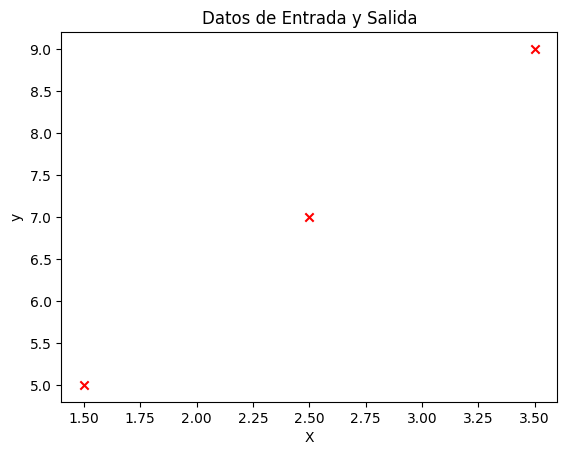

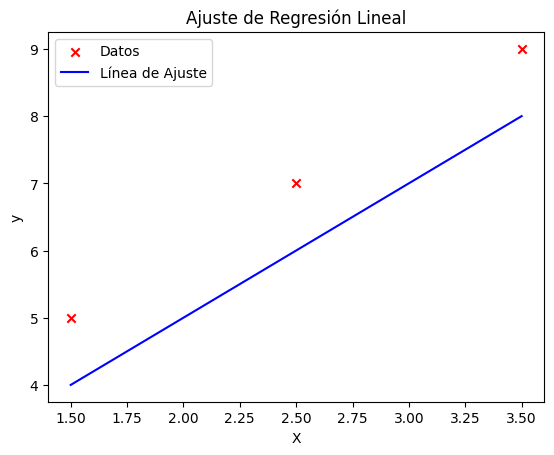

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plotData(X, y):
    """
    Función para graficar los datos de entrada X y los valores y.
    """
    plt.figure()
    plt.scatter(X, y, marker='x', color='r')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Datos de Entrada y Salida')
    plt.show()

def plotFit(X, y, theta):
    """
    Función para graficar la línea de ajuste sobre los datos.
    """
    plt.figure()
    plt.scatter(X[:, 1], y, marker='x', color='r', label='Datos')

    # Crear un rango de valores para la línea de ajuste
    x_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100).reshape(-1, 1)
    x_range = np.concatenate([np.ones((x_range.shape[0], 1)), x_range], axis=1)

    # Graficar la línea de ajuste
    plt.plot(x_range[:, 1], x_range @ theta, '-', color='b', label='Línea de Ajuste')

    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Ajuste de Regresión Lineal')
    plt.legend()
    plt.show()

# Supongamos que ya tienes los siguientes datos
X = np.array([[1, 1.5], [1, 2.5], [1, 3.5]])
y = np.array([5.0, 7.0, 9.0])
theta = np.array([1.0, 2.0])  # Ejemplo de valores de theta

# Graficar los datos
plotData(X[:, 1], y)

# Graficar la línea de ajuste
plotFit(X, y, theta)


In [24]:
X_array = [1, 23, 529]
X_array[1:3] = (X_array[1:3] - mu) / sigma

ValueError: operands could not be broadcast together with shapes (2,) (6,) 

In [ ]:
X_array[1:3]
print(np.dot(X_array, theta))

<a id="section7"></a>
### 2.3 Ecuacion de la Normal

Una manera de calcular rapidamente el modelo de una regresion lineal es:

$$ \theta = \left( X^T X\right)^{-1} X^T\vec{y}$$

Utilizando esta formula no requiere que se escale ninguna caracteristica, y se obtendra una solucion exacta con un solo calculo: no hay “bucles de convergencia” como en el descenso por el gradiente.

Primero se recargan los datos para garantizar que las variables no esten modificadas. Recordar que no es necesario escalar las caracteristicas, se debe agregar la columna de unos a la matriz $X$ para tener el termino de intersección($\theta_0$).

In [ ]:
# Cargar datos
data = np.loadtxt('/content/gdrive/MyDrive/Colab Notebooks/machine learning/Datasets/capacidad_adquisitiva.csv', delimiter=";",skiprows=1)
X = data[:, :1]
y = data[:, 1]
m = y.size
X_original = X.copy()
X = np.concatenate([X, X * X], axis=1)
X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [ ]:
def normalEqn(X, y):

    theta = np.zeros(X.shape[1])

    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)

    return theta

In [ ]:
# Calcula los parametros con la ecuación de la normal
theta = normalEqn(X, y);

# Muestra los resultados optenidos a partir de la aplicación de la ecuación de la normal
print('Theta calculado a partir de la ecuación de la normal: {:s}'.format(str(theta)));

# Estimar el precio para una casa de superficie de 1650 sq-ft y tres dormitorios

X_array = [1, 20, 400]
price = np.dot(X_array, theta)

print('Precio predecido para una cada de superficie de 1650 sq-ft y 3 dormitorios (usando la ecuación de la normal): ${:.0f}'.format(price))

In [ ]:
plotData(X[:, 1], y)
#X = np.concatenate([np.ones((m, 1)), X], axis=1)
#X = np.concatenate([X, X * X], axis=1)

pyplot.plot(X[:, 1], np.dot(X, theta), '-')